$\LARGE{\textbf{Beyond the Two-Level System}}$

# Report

## Introduction

## Problem and Method

$$\alpha \equiv \omega_{1} - \omega_{0} \equiv \omega^{1 \rightarrow 2} - \omega^{0 \rightarrow 1}$$

## Results

## Conclusion

## Appendix

# Code

## Setup

In [3]:
## general qiskit imports

import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
from qiskit import IBMQ
import numpy as np
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import schedule
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qutip import destroy

In [4]:
## save IBMQ account token

IBMQ.save_account('109f33eab1cac8f7fb13d4132013ccb6409a348c9b3fde61e13fdf41730a7949e314860eb3f9d9a62819080f6dd0af11a16d7632551e2e96e3d7a3a03e309b39', overwrite=True)

In [5]:
## load IBMQ account and set the appropriate backend

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [6]:
## verify that the backend supports Pulse features by checking the backend configuration

backend_config = backend.configuration()

In [7]:
##  find the sampling time for the backend pulses within the backend configuration

dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [8]:
## use granurality to determine the length of the pulse

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

In [9]:
## find least common multiple

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

Least common multiple of acquire_alignment and pulse_alignment: 16


In [10]:
## access estimates for qubit frequencies and default programs to enact basic quantum operators

backend_defaults = backend.defaults()

## Task 1

### Find the frequency of the |0⟩ → |1⟩ transition

In [11]:
## define frequency range for sweep in search of the qubit, restricting to a window of 40 MHz around the estimated qubit frequency

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.962283256340941 GHz.
The sweep will go from 4.94228325634094 GHz to 4.98228325634094 GHz in steps of 1.0 MHz.


In [12]:
## define helper functions for pulse flow

# drive pulse of a frequency
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

# determine the length of the pulse
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

# adjust the length of the delay
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [13]:
## create a pulse schedule

# Drive pulse parameters
drive_sigma_sec = 0.015 * us # actual width of the gaussian pulse
drive_duration_sec = drive_sigma_sec * 8 # truncating parameter, as gaussians don't have a natural finite length
drive_amp = 0.05

# Create the base schedule, start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [14]:
## create sweep

sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

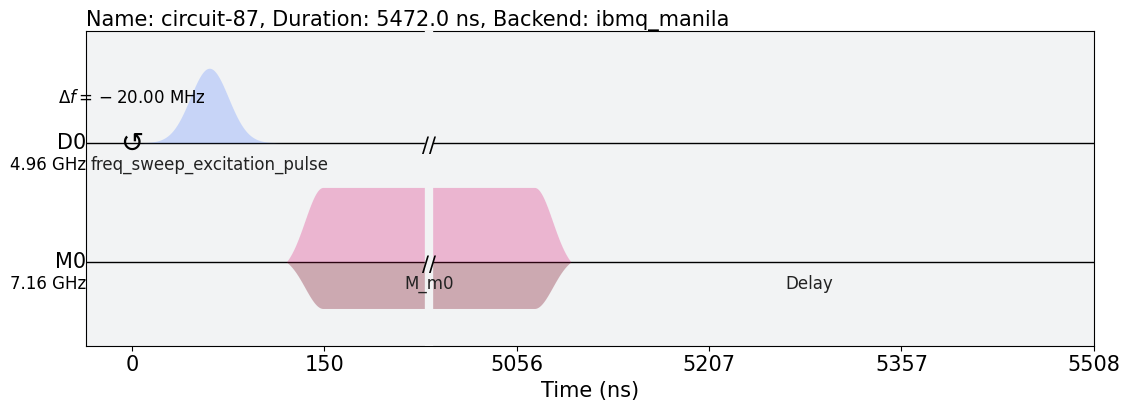

In [15]:
## draw sweep schedule

sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

In [16]:
## run assembled program on backend

num_shots_per_frequency = 1024

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In [17]:
## monitor job status

job_monitor(job)

Job Status: job has successfully run


In [18]:
## retrieve job results

frequency_sweep_results = job.result(timeout=120)

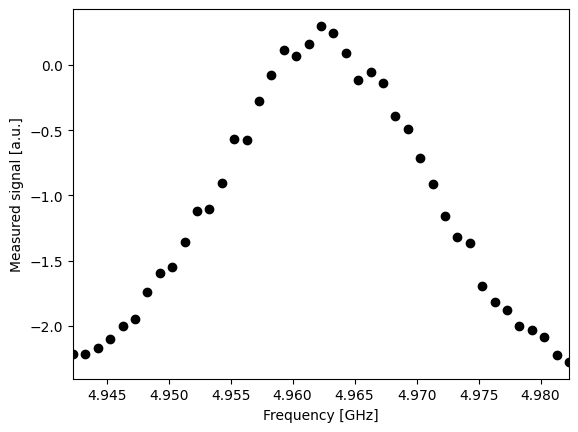

In [19]:
## plot job results

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

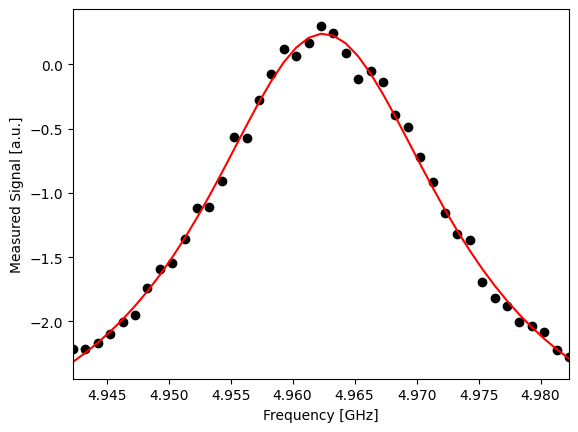

In [20]:
## fit values to a curve

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.975, 1, -2] # initial parameters for curve_fit
                                )

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [21]:
## derive frequency using peak

A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"Updated qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

Updated qubit frequency estimate from 4.96228 GHz to 4.96247 GHz.


### Calibrate the $\pi$ pulse for the |0⟩ → |1⟩ transition using a Rabi experiment

In [22]:
## Set Rabi experiment parameters

# Rabi experiment parameters
num_rabi_points = 75

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [23]:
## Build Rabi experiments

# A drive pulse at the qubit frequency, followed by a measurement, vary the drive amplitude each time
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [24]:
## create Rabi circuit

rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

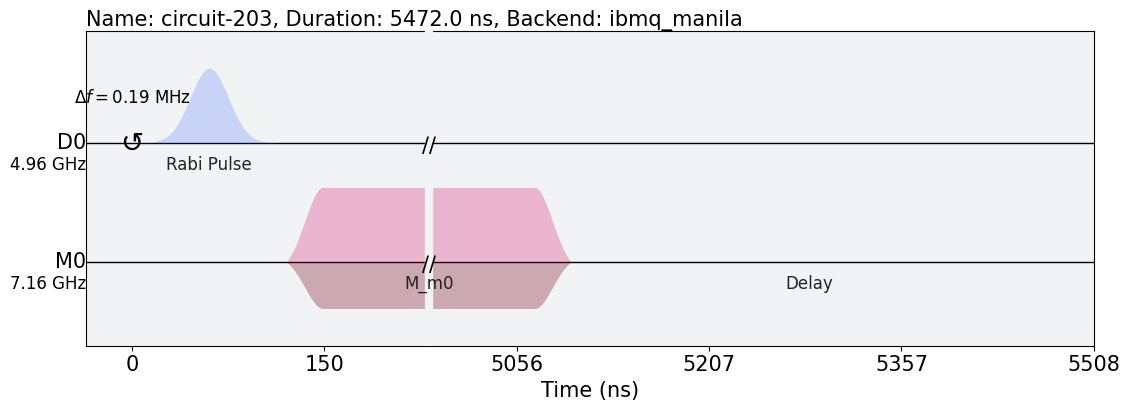

In [25]:
## draw Rabi schedule

rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [26]:
## run assembled program on backend

num_shots_per_point = 1024

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

In [27]:
## monitor job status

job_monitor(job)

Job Status: job has successfully run


In [28]:
## retrieve job results

rabi_results = job.result(timeout=120)

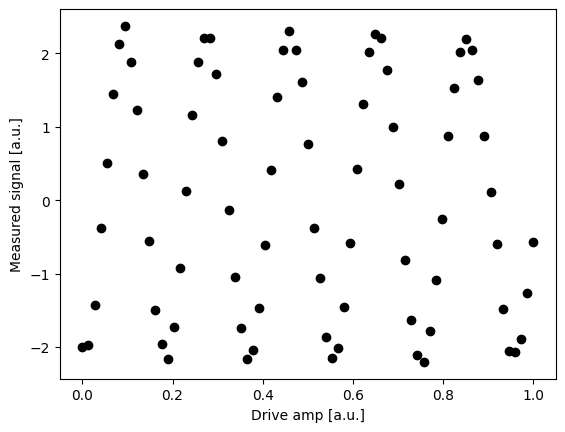

In [29]:
## plot job results

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

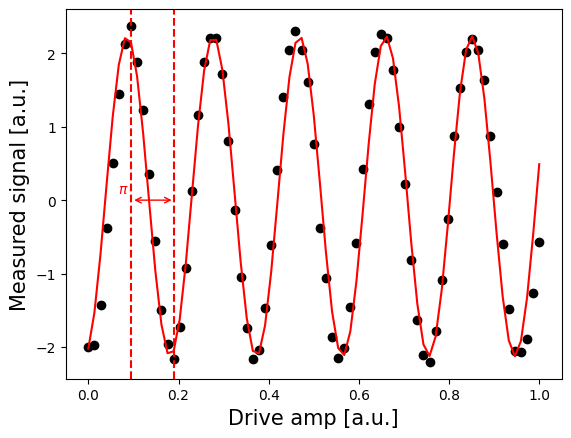

In [30]:
## fit values to a curve

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [-2, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

pi_amp = drive_period/2

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [31]:
## print pi amplitude

print(f"Pi Amplitude = {round(pi_amp, 5)}")

Pi Amplitude = 0.09556


## Task 2

### Find the frequency of the |1⟩ → |2⟩ transition

In [32]:
## define smaller range sweep
backend_properties = backend.properties()

default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz

num_freqs = 75
drive_power = 0.15
sweep_freqs = default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

# there are pulse parameters of the single qubit drive in IBM devices
x12_duration = 160
x12_sigma = 40

In [33]:
# helper function

def get_job_data(job, average):
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

In [34]:
## create a pulse schedule

freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=drive_power,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)

In [35]:
## excite qubit to the 1 state
spect_gate = Gate("spect", 1, [freq])
qc_spect = QuantumCircuit(1, 1)
qc_spect.x(0)
qc_spect.append(spect_gate, [0])
qc_spect.measure(0, 0)
qc_spect.add_calibration(spect_gate, (0,), freq12_sweep_sched, [freq])
    
exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

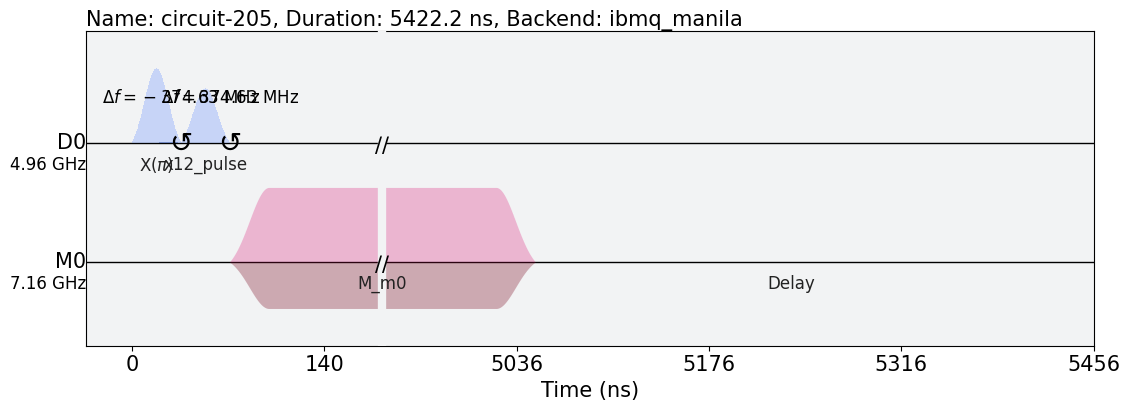

In [36]:
## draw sweep schedule

freq12_sweep_sched = schedule(exp_spect_circs[0], backend)
freq12_sweep_sched.draw(backend=backend)

In [37]:
## run assembled program on backend

num_shots_per_frequency = 1024

excited_freq_sweep_job = backend.run(exp_spect_circs, 
                                     meas_level=1, 
                                     meas_return='avg', 
                                     shots=num_shots_per_frequency)

In [38]:
## monitor job status

job_monitor(excited_freq_sweep_job)

Job Status: job has successfully run


In [39]:
## retrieve job results

excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
excited_sweep_freqs = rough_qubit_frequency + default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)
frequency_sweep_results = job.result(timeout=120)

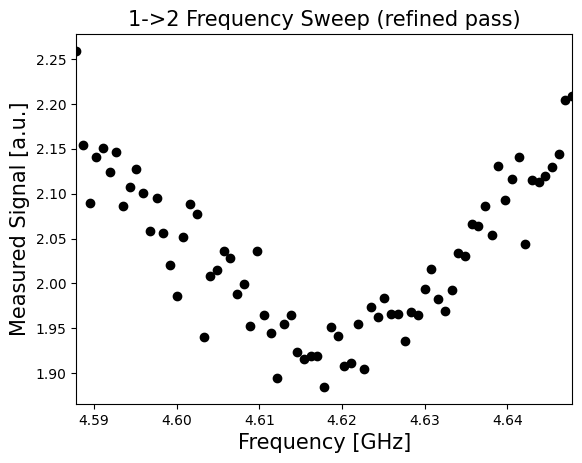

In [40]:
## plot job results

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

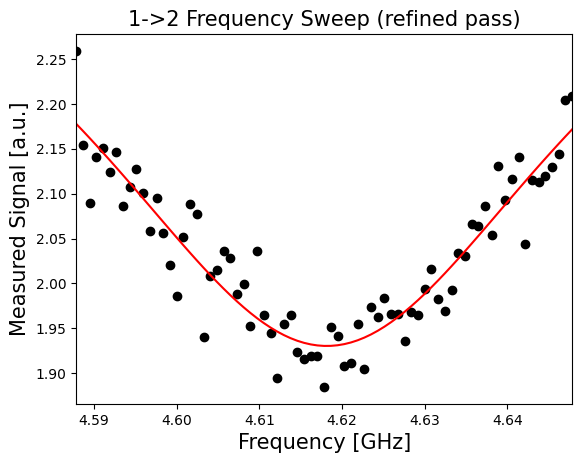

In [41]:
## fit values to a curve

(excited_sweep_fit_params, 
 excited_sweep_y_fit) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, 4.625*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

# Note: only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [42]:
## derive frequency using peak

_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"1->2 frequency: {round(qubit_12_freq/GHz, 5)} GHz.")

1->2 frequency: 4.61817 GHz.


### Calculate the anharmonicity of the qubit

In [43]:
## Calculate anharmonicity

anharmonicity_01_12 = qubit_12_freq - rough_qubit_frequency
print(f"Updated anharmonicity estimate from "
      f"{round(default_anharmonicity, 5)} GHz to {round(anharmonicity_01_12/GHz, 5)} GHz.")

Updated anharmonicity estimate from -0.34463 GHz to -0.34431 GHz.


### Calibrate the π pulse for the |1⟩ → |2⟩ transition using a Rabi experiment

In [44]:
## Set Rabi experiment parameters

num_rabi_points = 75

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [45]:
## Build Rabi experiments

# A drive pulse at the qubit frequency, followed by a measurement, vary the drive amplitude each time
amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=amp,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [46]:
## create Rabi circuit

rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.x(0)
qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [amp])
    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

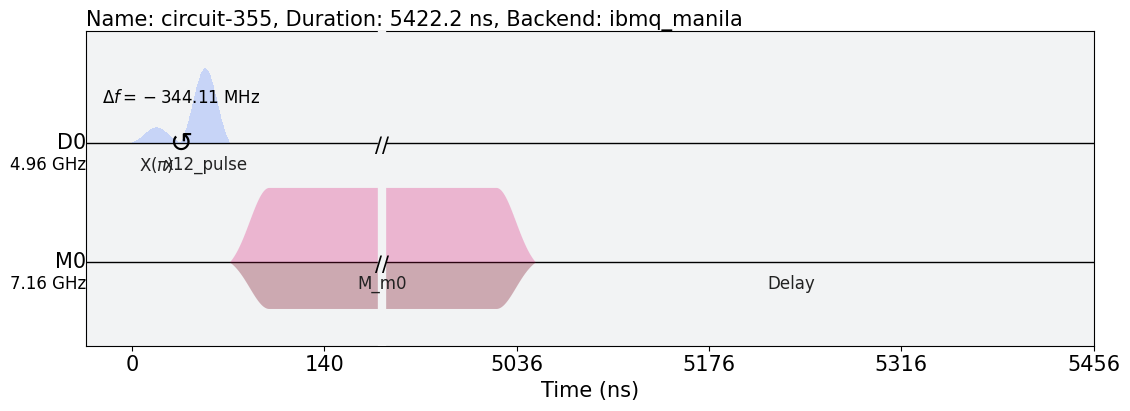

In [47]:
## draw Rabi schedule

rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [48]:
## run assembled program on backend

num_shots_per_frequency = 1024

rabi_12_job = backend.run(exp_rabi_circs, 
                          meas_level=1, 
                          meas_return='avg', 
                          shots=num_shots_per_frequency)

In [49]:
## monitor job status

job_monitor(rabi_12_job)

Job Status: job has successfully run


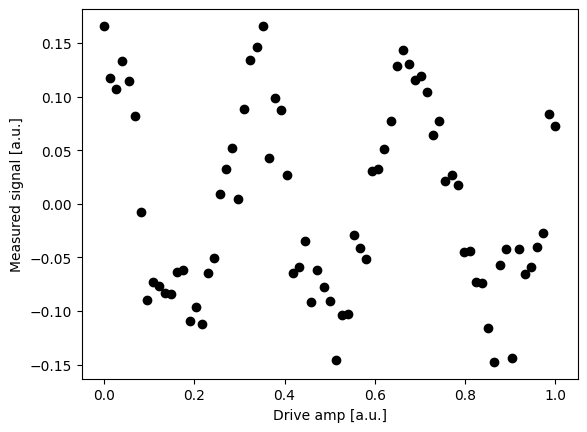

In [50]:
## retrieve job results

rabi_12_data = np.real(baseline_remove(get_job_data(rabi_12_job, average=True)))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_12_data, color='black') # plot real part of Rabi values
plt.show()

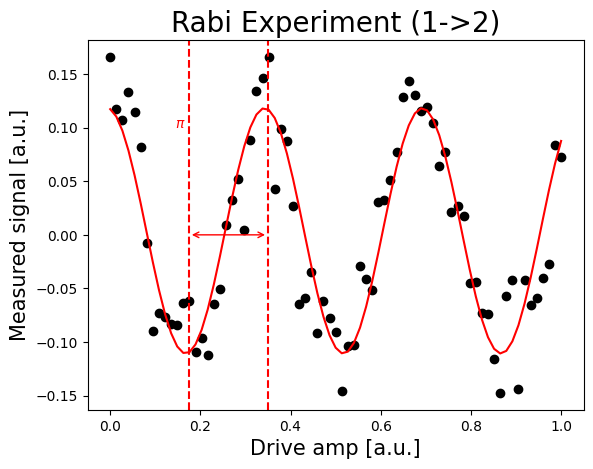

In [51]:
## fit values to a curve

(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                               rabi_12_data, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [0.2, 0, 0.3, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2] 

pi_amp_12 = drive_12_period/2

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [52]:
## print pi amplitude

print(f"Pi Amplitude (1->2) = {round(pi_amp_12, 5)}")

Pi Amplitude (1->2) = 0.17481


## Task 3

### Build an IQ discriminator for distinguishing the states into |0⟩, |1⟩, and |2⟩

In [53]:
## Schedule pulse from 1->2

with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [54]:
## Create 3 circuits

# 0 state
qc_ground = QuantumCircuit(1, 1)
qc_ground.measure(0, 0)

# 1 state
qc_one = QuantumCircuit(1, 1)
qc_one.x(0)
qc_one.measure(0, 0)

# 2 state 
x12_gate = Gate("one_two_pulse", 1, [])
qc_x12 = QuantumCircuit(1, 1)
qc_x12.x(0)
qc_x12.append(x12_gate, [0])
qc_x12.measure(0, 0)
qc_x12.add_calibration(x12_gate, (0,), x12_sched, [])

In [55]:
## run assembled program on backend

num_shots_per_frequency = 1024

IQ_012_job = backend.run([qc_ground, qc_one, qc_x12], 
                          meas_level=1, 
                          meas_return='single', 
                          shots=num_shots_per_frequency)

In [56]:
## monitor job status

job_monitor(IQ_012_job)

Job Status: job has successfully run


In [57]:
## retrieve job results

IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

Text(0.5, 1.0, '0-1 discrimination')

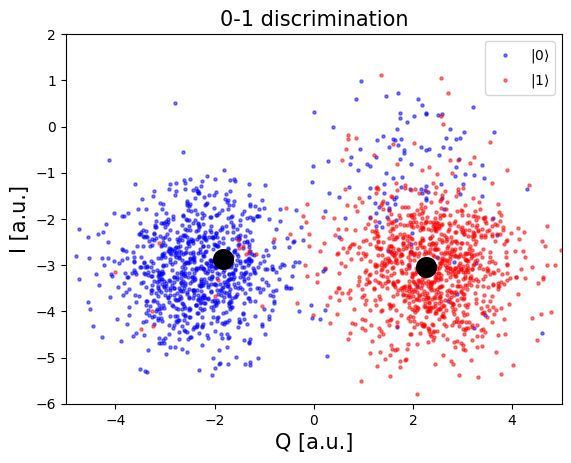

In [58]:
## plot the distributions of 0, 1

plt.scatter(np.real(zero_data), np.imag(zero_data), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
# one data plotted in red
plt.scatter(np.real(one_data), np.imag(one_data), 
                s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')

# Plot a large dot for the average result of the 0, 1 and 2 states.
mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
mean_one = np.mean(one_data)
plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_one), np.imag(mean_one), 
            s=200, cmap='viridis', c='black',alpha=1.0)

plt.xlim(-5, 5)
plt.ylim(-6, 2)
plt.legend()
plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

Text(0.5, 1.0, '0-1-2 discrimination')

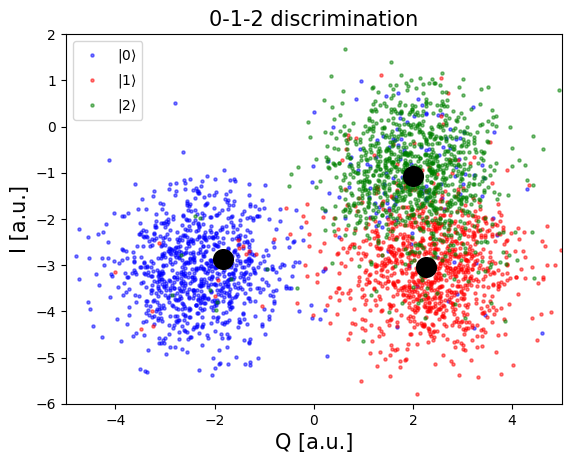

In [59]:
## plot the distributions for 0, 1, 2

# one data plotted in blue
plt.scatter(np.real(zero_data), np.imag(zero_data), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
# one data plotted in red
plt.scatter(np.real(one_data), np.imag(one_data), 
                s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
# two data plotted in green
plt.scatter(np.real(two_data), np.imag(two_data), 
                s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

# Plot a large dot for the average result of the 0, 1 and 2 states.
mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
mean_one = np.mean(one_data)
mean_two = np.mean(two_data)
plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_one), np.imag(mean_one), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_two), np.imag(mean_two), 
            s=200, cmap='viridis', c='black',alpha=1.0)

plt.xlim(-5, 5)
plt.ylim(-6, 2)
plt.legend()
plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1-2 discrimination", fontsize=15)

### Create a classifier to define the qubit state

Text(0.5, 1.0, '0-1-2 discrimination')

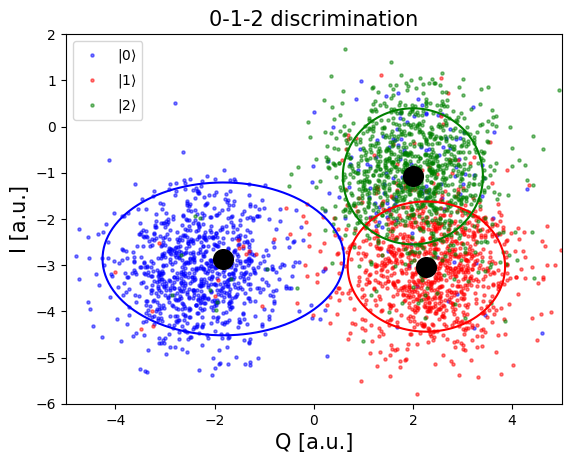

In [60]:
## draw classifier for 0, 1, 2

# helper function
def draw_ellipse(c, q_center, i_center, q_radius, i_radius):
    t = np.linspace(0,360,360)
    q = q_center + q_radius*np.cos(np.radians(t))
    i = i_center + i_radius*np.sin(np.radians(t))
    plt.plot(q, i, c=c)

# zero data plotted in blue
plt.scatter(np.real(zero_data), np.imag(zero_data), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
# one data plotted in red
plt.scatter(np.real(one_data), np.imag(one_data), 
                s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
# two data plotted in green
plt.scatter(np.real(two_data), np.imag(two_data), 
                s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

# Plot a large dot for the average result of the 0, 1 and 2 states.
mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
mean_one = np.mean(one_data)
mean_two = np.mean(two_data)

q_center_zero, i_center_zero = np.real(mean_zero), np.imag(mean_zero)
plt.scatter(q_center_zero, i_center_zero, 
            s=200, cmap='viridis', c='black',alpha=1.0)
q_center_one, i_center_one = np.real(mean_one), np.imag(mean_one)
plt.scatter(q_center_one, i_center_one, 
            s=200, cmap='viridis', c='black',alpha=1.0)
q_center_two, i_center_two = np.real(mean_two), np.imag(mean_two)
plt.scatter(q_center_two, i_center_two,
            s=200, cmap='viridis', c='black',alpha=1.0)

std_devs = 1.5
q_axis_zero, i_axis_zero = std_devs*np.std(np.real(zero_data)), std_devs*np.std(np.imag(zero_data))
draw_ellipse('blue', q_center_zero, i_center_zero, q_axis_zero, i_axis_zero)
q_axis_one, i_axis_one = std_devs*np.std(np.real(one_data)), std_devs*np.std(np.imag(one_data))
draw_ellipse('red', q_center_one, i_center_one, q_axis_one, i_axis_one)
q_axis_two, i_axis_two = std_devs*np.std(np.real(two_data)), std_devs*np.std(np.imag(two_data))
draw_ellipse('green', q_center_two, i_center_two, q_axis_two, i_axis_two)

plt.xlim(-5, 5)
plt.ylim(-6, 2)
plt.legend()
plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1-2 discrimination", fontsize=15)

In [61]:
## classify points

def classify_inside(point, ellipses):
    classified = -1
    distance_to_classified = np.Infinity
    ct = 0
    for ellipse in ellipses:
        q_center, i_center, q_axis, i_axis = ellipse
        squared_sum = ((np.real(point) - q_center) / q_axis) ** 2 + ((np.imag(point) - i_center) / i_axis) ** 2
        if squared_sum <= 1 and squared_sum < distance_to_classified:
            classified = ct
            distance_to_classified = squared_sum
        ct += 1
    return classified

def classify_closest(point, ellipses):
    classified = -1
    distance_to_classified = np.Infinity
    ct = 0
    for ellipse in ellipses:
        q_center, i_center, q_axis, i_axis = ellipse
        squared_sum = ((np.real(point) - q_center) / q_axis) ** 2 + ((np.imag(point) - i_center) / i_axis) ** 2
        if squared_sum < distance_to_classified:
            classified = ct
            distance_to_classified = squared_sum
        ct += 1
    return classified

## Task 4

### Estimate the occupation probability for |0⟩, |1⟩, and |2⟩ near the calibrated $\pi$ pulse of the |0⟩ → |1⟩ transition

In [62]:
## Set Rabi experiment parameters

# Rabi experiment parameters
num_rabi_points = 75
gap = 0.05

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = pi_amp - gap / 2
drive_amp_max = pi_amp + gap / 2
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [63]:
## create a pulse schedule

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [64]:
## create Rabi circuit

rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

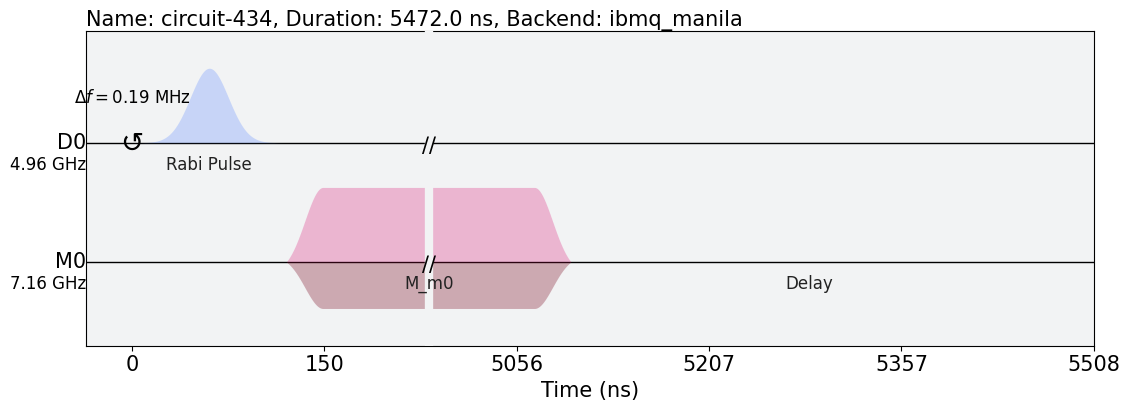

In [65]:
## draw Rabi schedule

rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [66]:
## run assembled program on backend

num_shots_per_point = 1024

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots_per_point)

In [67]:
## monitor job status

job_monitor(job)

Job Status: job has successfully run


In [68]:
## retrieve job results

rabi_results = job.result(timeout=120)

In [69]:
## classify results

ellipses = [(q_center_zero, i_center_zero, q_axis_zero, i_axis_zero),
            (q_center_one, i_center_one, q_axis_one, i_axis_one),
            (q_center_two, i_center_two, q_axis_two, i_axis_two)]
            
amp_states = []
amp_classifications_inside = []
amp_classifications_closest = []

for j in range(75):
    states = []
    classifications_inside = []
    classifications_closest = []
    for i in range(num_rabi_points):
        state = rabi_results.get_memory(i)[j]
        states.append(state)
        classifications_inside.append(classify_inside(state * scale_factor, ellipses))
        classifications_closest.append(classify_closest(state * scale_factor, ellipses))

    amp_states.append(np.array(states))
    amp_classifications_inside.append(np.array(classifications_inside))
    amp_classifications_closest.append(np.array(classifications_closest))

In [70]:
max_probability = 0
probabilities_inside = []
probabilities_closest = []
for j in range(len(amp_classifications_inside)):
    num_escaped_inside = np.count_nonzero(amp_classifications_inside[j] == -1) + np.count_nonzero(amp_classifications_inside[j] == 2)
    probability_inside = num_escaped_inside / num_rabi_points
    probabilities_inside.append(probability_inside)
for j in range(len(amp_classifications_closest)):
    num_escaped_closest = np.count_nonzero(amp_classifications_closest[j] == -1) + np.count_nonzero(amp_classifications_closest[j] == 2)
    probability_closest = num_escaped_closest / num_rabi_points
    probabilities_closest.append(probability_closest)

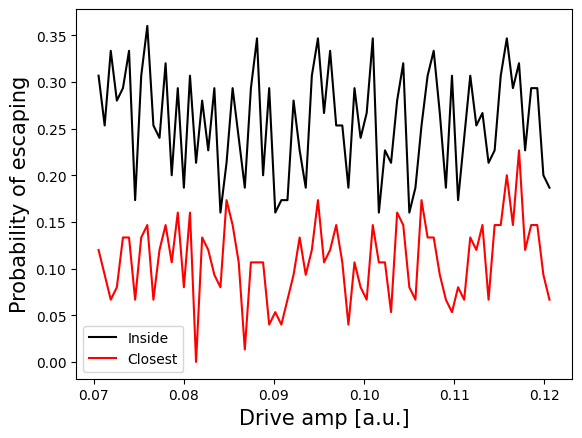

In [71]:
plt.plot(drive_amps, probabilities_inside, color='black', label='Inside')
plt.plot(drive_amps, probabilities_closest, color='red', label='Closest')

plt.legend()
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Probability of escaping", fontsize=15)
plt.show()

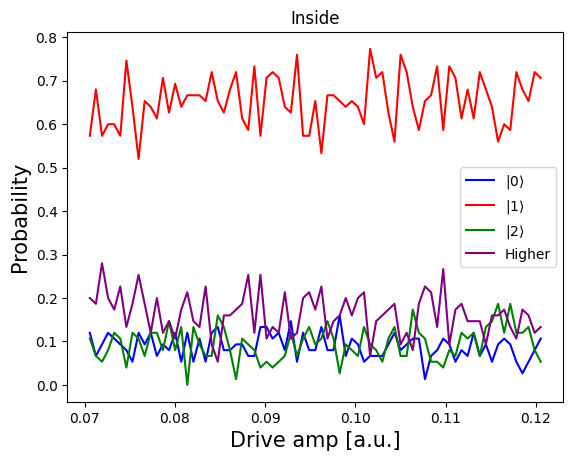

In [74]:
## plot probabilities

zero_probabilities_inside = []
one_probabilities_inside = []
two_probabilities_inside = []
higher_probabilities_inside = []
for j in range(len(amp_classifications_inside)):
    num_zero = np.count_nonzero(amp_classifications_inside[j] == 0)
    zero_probabilities_inside.append(num_zero / num_rabi_points)
    num_one = np.count_nonzero(amp_classifications_inside[j] == 1)
    one_probabilities_inside.append(num_one / num_rabi_points)
    num_two = np.count_nonzero(amp_classifications_inside[j] == 2)
    two_probabilities_inside.append(num_two / num_rabi_points)
    num_higher = np.count_nonzero(amp_classifications_inside[j] == -1)
    higher_probabilities_inside.append(num_higher / num_rabi_points)

plt.plot(drive_amps, zero_probabilities_inside, color='blue', label=r'$|0\rangle$')
plt.plot(drive_amps, one_probabilities_inside, color='red', label=r'$|1\rangle$')
plt.plot(drive_amps, two_probabilities_inside, color='green', label=r'$|2\rangle$')
plt.plot(drive_amps, higher_probabilities_inside, color='purple', label='Higher')

plt.title('Inside')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.legend()
plt.show()

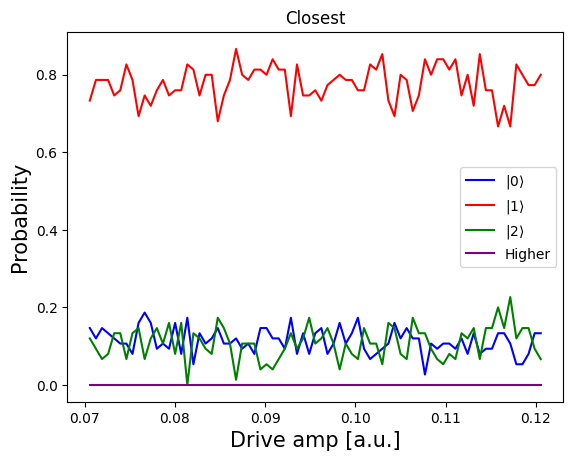

In [77]:
## plot probabilities

zero_probabilities_closest = []
one_probabilities_closest = []
two_probabilities_closest = []
higher_probabilities_closest = []
for j in range(len(amp_classifications_closest)):
    num_zero = np.count_nonzero(amp_classifications_closest[j] == 0)
    zero_probabilities_closest.append(num_zero / num_rabi_points)
    num_one = np.count_nonzero(amp_classifications_closest[j] == 1)
    one_probabilities_closest.append(num_one / num_rabi_points)
    num_two = np.count_nonzero(amp_classifications_closest[j] == 2)
    two_probabilities_closest.append(num_two / num_rabi_points)
    num_higher = np.count_nonzero(amp_classifications_closest[j] == -1)
    higher_probabilities_closest.append(num_higher / num_rabi_points)

plt.plot(drive_amps, zero_probabilities_closest, color='blue', label=r'$|0\rangle$')
plt.plot(drive_amps, one_probabilities_closest, color='red', label=r'$|1\rangle$')
plt.plot(drive_amps, two_probabilities_closest, color='green', label=r'$|2\rangle$')
plt.plot(drive_amps, higher_probabilities_closest, color='purple', label='Higher')

plt.title('Closest')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.legend()
plt.show()

### Plot the IQ data for drive power with sizable probability of escaping the manifold

In [72]:
## find max probability of escape
max_probability_index_inside = np.argmax(probabilities_inside)
max_probability_inside = probabilities_inside[max_probability_index_inside]
max_amps_inside = drive_amps[max_probability_index_inside]
max_states_inside = amp_states[max_probability_index_inside]
max_classifications_inside = amp_classifications_inside[max_probability_index_inside]
print(f"Inside")
print(f"Amps = {round(max_amps_inside, 5)}")
print(f"Probability of Escape = {round(max_probability_inside, 5)}")

Inside
Amps = 0.07596
Probability of Escape = 0.36


Text(0.5, 1.0, 'Inside')

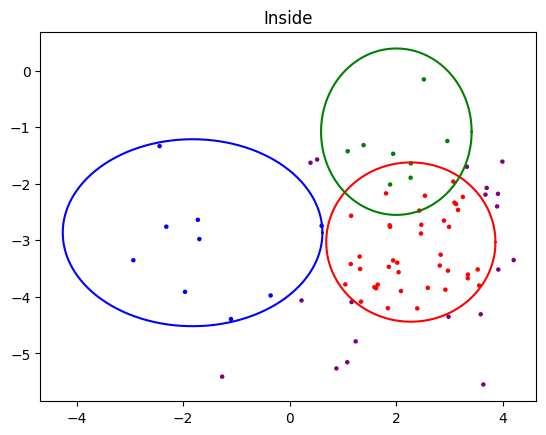

In [73]:
## show classifier of max probability of escape
color = np.where(max_classifications_inside == 0, 'blue',
        np.where(max_classifications_inside == 1, 'red',
        np.where(max_classifications_inside == 2, 'green',
        'purple')))
plt.scatter(np.real(max_states_inside) * scale_factor, np.imag(max_states_inside) * scale_factor, 
                s=5, cmap='viridis', c=color)
draw_ellipse('blue', q_center_zero, i_center_zero, q_axis_zero, i_axis_zero)
draw_ellipse('red', q_center_one, i_center_one, q_axis_one, i_axis_one)
draw_ellipse('green', q_center_two, i_center_two, q_axis_two, i_axis_two)

plt.title('Inside')

In [75]:
## find max probability of escape
max_probability_index_closest = np.argmax(probabilities_closest)
max_probability_closest = probabilities_closest[max_probability_index_closest]
max_amps_closest = drive_amps[max_probability_index_closest]
max_states_closest = amp_states[max_probability_index_closest]
max_classifications_closest = amp_classifications_closest[max_probability_index_closest]
print(f"Closest")
print(f"Amps = {round(max_amps_closest, 5)}")
print(f"Probability of Escape = {round(max_probability_closest, 5)}")

Closest
Amps = 0.11718
Probability of Escape = 0.22667


Text(0.5, 1.0, 'Closest')

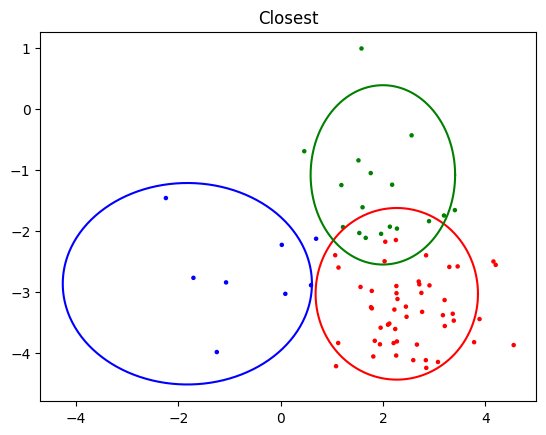

In [76]:
## show classifier of max probability of escape
color = np.where(max_classifications_closest == 0, 'blue',
        np.where(max_classifications_closest == 1, 'red',
        np.where(max_classifications_closest == 2, 'green',
        'purple')))
plt.scatter(np.real(max_states_closest) * scale_factor, np.imag(max_states_closest) * scale_factor, 
                s=5, cmap='viridis', c=color)
draw_ellipse('blue', q_center_zero, i_center_zero, q_axis_zero, i_axis_zero)
draw_ellipse('red', q_center_one, i_center_one, q_axis_one, i_axis_one)
draw_ellipse('green', q_center_two, i_center_two, q_axis_two, i_axis_two)

plt.title('Closest')

## Bonus

### Find the frequency of the |2⟩ → |3⟩ transition

In [78]:
## define smaller range sweep
backend_properties = backend.properties()

freq_guess = qubit_12_freq + anharmonicity_01_12
power_guess = 0.275
num_freqs = 100
sweep_freqs = freq_guess + np.linspace(-300*MHz, 300*MHz, num_freqs)

# there are pulse parameters of the single qubit drive in IBM devices
x12_duration = 160
x12_sigma = 40
x23_duration = 160
x23_sigma = 40

In [79]:
## create a pulse schedule
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

qubit_23_freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq23_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_23_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x23_duration,
                                amp=power_guess,
                                sigma=x23_sigma,
                                name='x23_pulse'), drive_chan)

In [113]:
# prepare state

x12_gate = Gate("one_two_pulse", 1, [])
sweep_23_gate = Gate("two_three_pulse", 1, [qubit_23_freq])
qc_x23 = QuantumCircuit(1, 1)
qc_x23.x(0)
qc_x23.append(x12_gate, [0])
qc_x23.append(sweep_23_gate, [0])
qc_x23.measure(0, 0)
qc_x23.add_calibration(x12_gate, (0,), x12_sched, [])
qc_x23.add_calibration(sweep_23_gate, (0,), freq23_sweep_sched, [qubit_23_freq])
    
exp_x23_circs = [qc_x23.assign_parameters({qubit_23_freq: f}) for f in sweep_freqs]

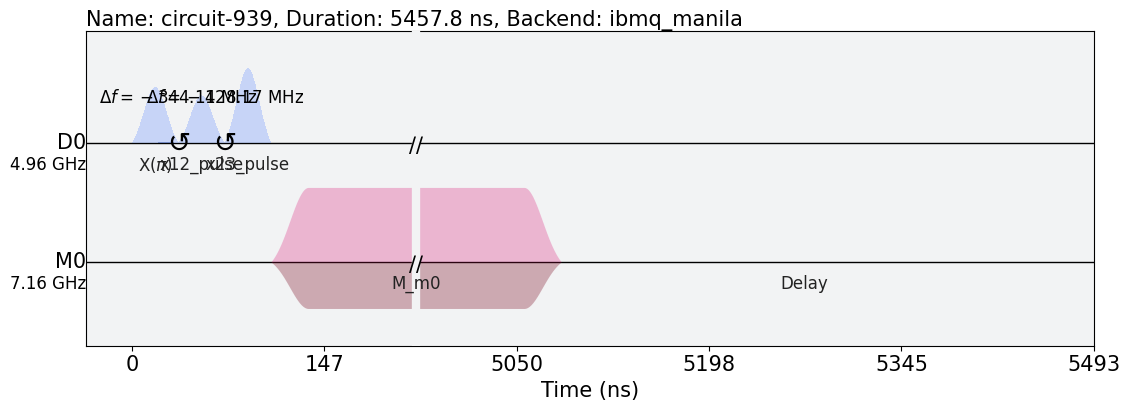

In [114]:
## draw sweep schedule

freq23_sweep_sched = schedule(exp_x23_circs[0], backend)
freq23_sweep_sched.draw(backend=backend)

In [82]:
## run assembled program on backend

num_shots_per_frequency = 1024

excited_freq_sweep_job = backend.run(exp_x23_circs, 
                                     meas_level=1, 
                                     meas_return='avg', 
                                     shots=num_shots_per_frequency)

In [83]:
## monitor job status

job_monitor(excited_freq_sweep_job)

Job Status: job has successfully run


In [84]:
## retrieve job results

excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
frequency_sweep_results = job.result(timeout=120)

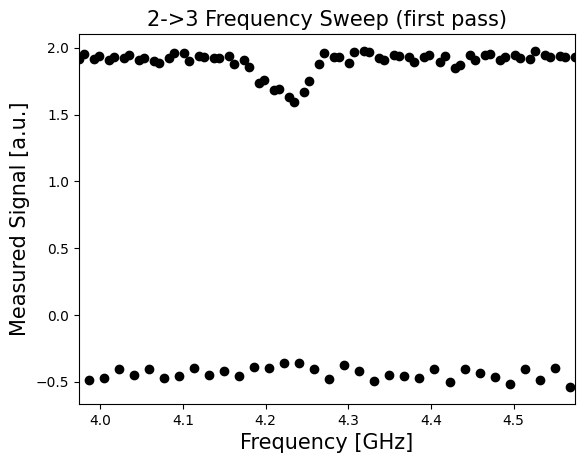

In [85]:
## plot job results

plt.scatter(sweep_freqs / GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(sweep_freqs / GHz), max(sweep_freqs / GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("2->3 Frequency Sweep (first pass)", fontsize=15)
plt.show()

In [115]:
freq_guess = 4.22

num_freqs = 75
sweep_freqs = freq_guess*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

In [116]:
## create a pulse schedule
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

qubit_23_freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq23_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_23_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x23_duration,
                                amp=power_guess,
                                sigma=x23_sigma,
                                name='x23_pulse'), drive_chan)

In [118]:
# prepare state

x12_gate = Gate("one_two_pulse", 1, [])
sweep_23_gate = Gate("two_three_pulse", 1, [qubit_23_freq])
qc_x23 = QuantumCircuit(1, 1)
qc_x23.x(0)
qc_x23.append(x12_gate, [0])
qc_x23.append(sweep_23_gate, [0])
qc_x23.measure(0, 0)
qc_x23.add_calibration(x12_gate, (0,), x12_sched, [])
qc_x23.add_calibration(sweep_23_gate, (0,), freq23_sweep_sched, [qubit_23_freq])
    
exp_x23_circs = [qc_x23.assign_parameters({qubit_23_freq: f}) for f in sweep_freqs]

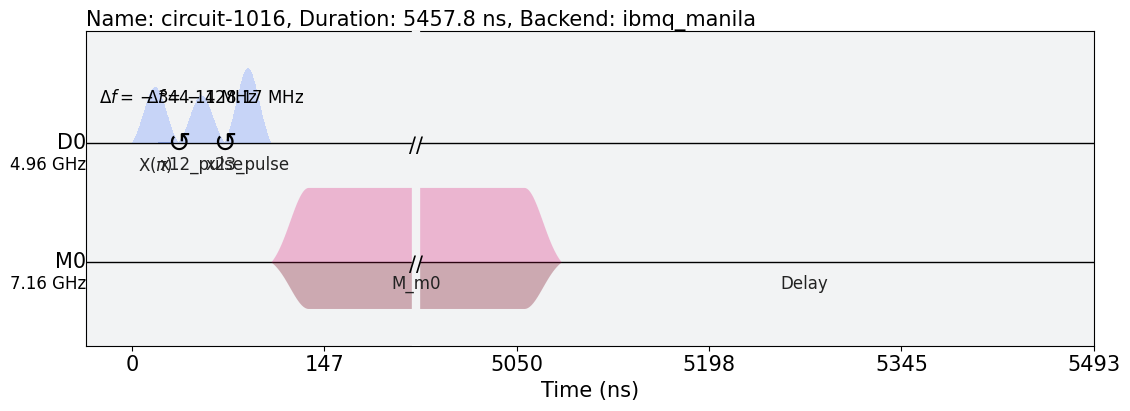

In [119]:
## draw sweep schedule

freq23_sweep_sched = schedule(exp_x23_circs[0], backend)
freq23_sweep_sched.draw(backend=backend)

In [120]:
## run assembled program on backend

num_shots_per_frequency = 1024

excited_freq_sweep_job = backend.run(exp_x23_circs, 
                                     meas_level=1, 
                                     meas_return='avg', 
                                     shots=num_shots_per_frequency)

In [121]:
## monitor job status

job_monitor(excited_freq_sweep_job)

Job Status: job has successfully run


In [91]:
## retrieve job results

excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
frequency_sweep_results = job.result(timeout=120)

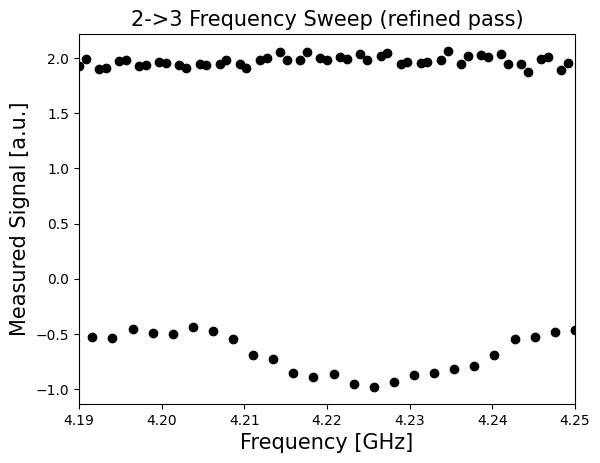

In [123]:
## plot job results

plt.scatter(sweep_freqs / GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(sweep_freqs / GHz), max(sweep_freqs / GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("2->3 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

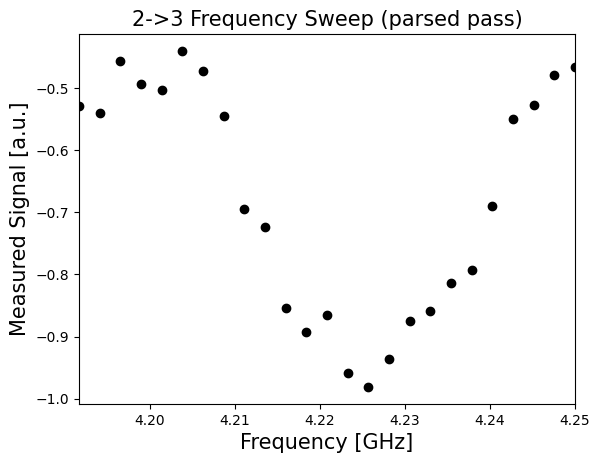

In [125]:
## parse job results
num_points = 25
parsed_indices = np.sort(np.argsort(excited_freq_sweep_data)[:num_points])
sweep_freqs_parsed = sweep_freqs[parsed_indices]
excited_freq_sweep_data_parsed = np.array(excited_freq_sweep_data)[parsed_indices]

plt.scatter(sweep_freqs_parsed/GHz, excited_freq_sweep_data_parsed, color='black')
plt.xlim([min(sweep_freqs_parsed/GHz), max(sweep_freqs_parsed/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("2->3 Frequency Sweep (parsed pass)", fontsize=15)
plt.show()

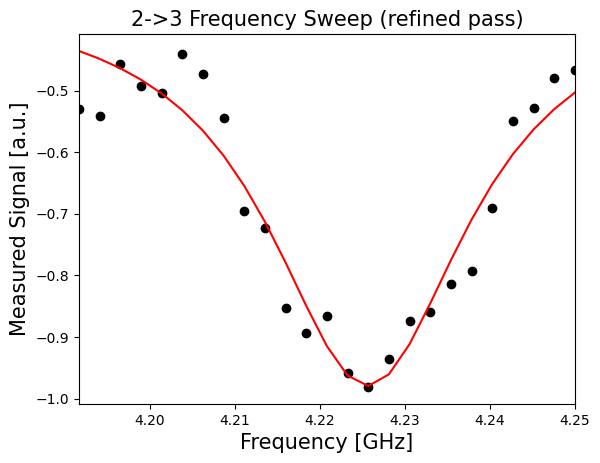

In [127]:
## fit values to a curve

(excited_sweep_fit_params, 
 excited_sweep_y_fit) = fit_function(sweep_freqs_parsed,
                                     excited_freq_sweep_data_parsed, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-30, 4.22*GHz, 0.02*GHz, -0.9*GHz] # initial parameters for curve_fit
                                     )

# Note: only plotting the real part of the signal
plt.scatter(sweep_freqs_parsed/GHz, excited_freq_sweep_data_parsed, color='black')
plt.plot(sweep_freqs_parsed/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(sweep_freqs_parsed/GHz), max(sweep_freqs_parsed/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("2->3 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [128]:
## derive frequency using peak

_, qubit_23_freq, _, _ = excited_sweep_fit_params
print(f"2->3 frequency: {round(qubit_23_freq/GHz, 5)} GHz.")

2->3 frequency: 4.22561 GHz.


### Calibrate the $\pi$ pulse for the |2⟩ → |3⟩ transition using a Rabi experiment

In [129]:
## Set Rabi experiment parameters

num_rabi_points = 100

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [130]:
## Build Rabi experiments

with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)
                              
# A drive pulse at the qubit frequency, followed by a measurement, vary the drive amplitude each time
amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched_23:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_23_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x23_duration,
                              amp=amp,
                              sigma=x23_sigma,
                              name='x23_pulse'), drive_chan)

In [131]:
## create Rabi circuit

x12_gate = Gate("one_two_pulse", 1, [])
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.x(0)
qc_rabi.append(x12_gate, [0])
qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(x12_gate, (0,), x12_sched, [])
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched_23, [amp])
    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

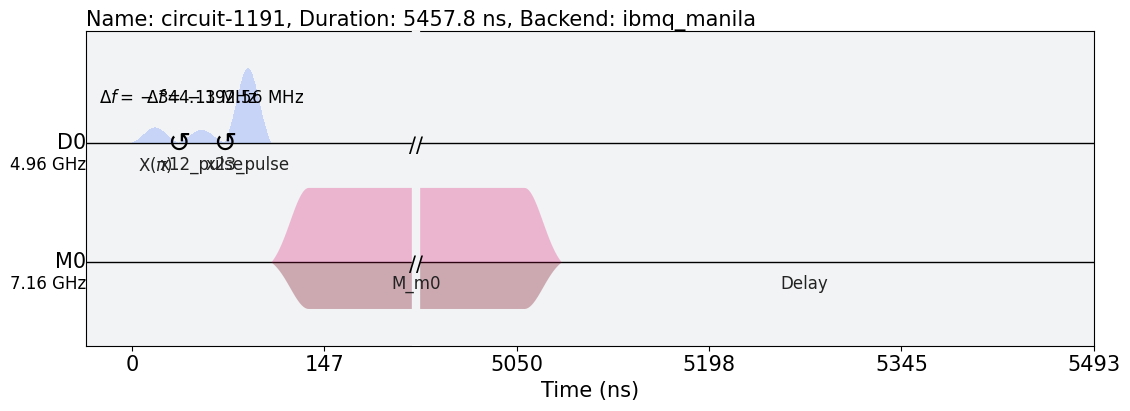

In [132]:
## draw Rabi schedule

rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [133]:
## run assembled program on backend

num_shots_per_frequency = 1024

rabi_23_job = backend.run(exp_rabi_circs, 
                          meas_level=1, 
                          meas_return='avg', 
                          shots=num_shots_per_frequency)

In [134]:
## monitor job status

job_monitor(rabi_23_job)

Job Status: job has successfully run


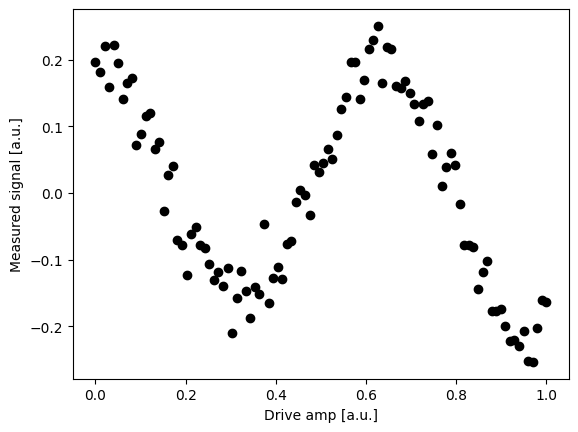

In [135]:
## retrieve job results

rabi_23_data = np.real(baseline_remove(get_job_data(rabi_23_job, average=True)))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_23_data, color='black') # plot real part of Rabi values
plt.show()

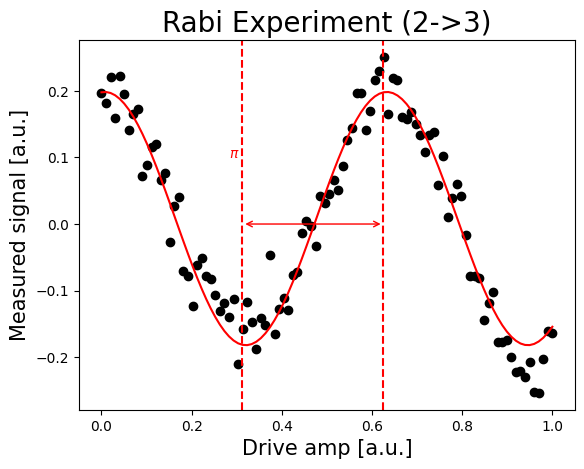

In [137]:
## fit values to a curve

(rabi_23_fit_params, 
 rabi_23_y_fit) = fit_function(drive_amps,
                               rabi_23_data, 
                               lambda x, A, B, drive_23_period, phi: (A*np.cos(2*np.pi*x/drive_23_period - phi) + B),
                               [0.2, -np.pi, 0.3, 0])

plt.scatter(drive_amps, rabi_23_data, color='black')
plt.plot(drive_amps, rabi_23_y_fit, color='red')

drive_23_period = rabi_23_fit_params[2] 

pi_amp_23 = drive_23_period/2

plt.axvline(pi_amp_23, color='red', linestyle='--')
plt.axvline(pi_amp_23+drive_23_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_23+drive_23_period/2, 0), xytext=(pi_amp_23,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_23-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (2->3)', fontsize=20)
plt.show()

In [138]:
## print pi amplitude

print(f"Pi Amplitude (2->3) = {round(pi_amp_23, 5)}")

Pi Amplitude (2->3) = 0.31272


### Build an IQ discriminator for distinguishing the states into |0⟩, |1⟩, |2⟩, and |3⟩

In [151]:
## Schedule pulse from 1->2 and 2->3

with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as x23_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_23_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x23_duration,
                              amp=pi_amp_23,
                              sigma=x23_sigma,
                              name='x23_pulse'), drive_chan)

In [152]:
## Create 4 circuits

# 0 state
qc_ground = QuantumCircuit(1, 1)
qc_ground.measure(0, 0)

# 1 state
qc_one = QuantumCircuit(1, 1)
qc_one.x(0)
qc_one.measure(0, 0)

# 2 state 
x12_gate = Gate("one_two_pulse", 1, [])
qc_two = QuantumCircuit(1, 1)
qc_two.x(0)
qc_two.append(x12_gate, [0])
qc_two.measure(0, 0)
qc_two.add_calibration(x12_gate, (0,), x12_sched, [])

# 3 state 
x23_gate = Gate("two_three_pulse", 1, [])
qc_three = QuantumCircuit(1, 1)
qc_three.x(0)
qc_three.append(x12_gate, [0])
qc_three.append(x23_gate, [0])
qc_three.measure(0, 0)
qc_three.add_calibration(x12_gate, (0,), x12_sched, [])
qc_three.add_calibration(x23_gate, (0,), x23_sched, [])

In [153]:
## run assembled program on backend

num_shots_per_frequency = 1024

IQ_0123_job = backend.run([qc_ground, qc_one, qc_two, qc_three], 
                          meas_level=1, 
                          meas_return='single', 
                          shots=num_shots_per_frequency)

In [154]:
## monitor job status

job_monitor(IQ_0123_job)

Job Status: job has successfully run


In [155]:
## retrieve job results

IQ_0123_data = get_job_data(IQ_0123_job, average=False)
zero_data = IQ_0123_data[0]
one_data = IQ_0123_data[1]
two_data = IQ_0123_data[2]
three_data = IQ_0123_data[3]

Text(0.5, 1.0, '0-1-2-3 discrimination')

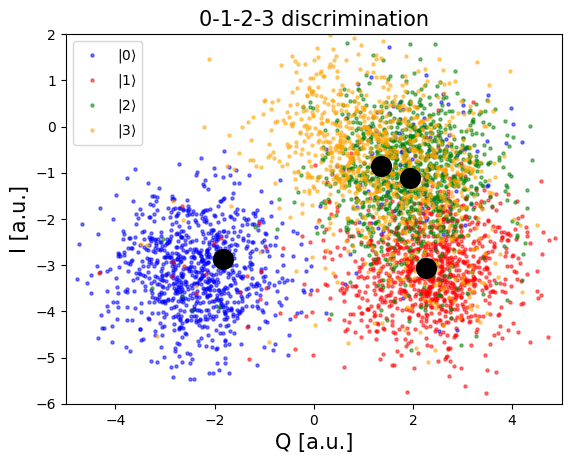

In [156]:
## plot the distributions for 0, 1, 2, 3

# one data plotted in blue
plt.scatter(np.real(zero_data), np.imag(zero_data), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
# one data plotted in red
plt.scatter(np.real(one_data), np.imag(one_data), 
                s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
# two data plotted in green
plt.scatter(np.real(two_data), np.imag(two_data), 
                s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')
# three data plotted in yellow
plt.scatter(np.real(three_data), np.imag(three_data), 
                s=5, cmap='viridis', c='orange', alpha=0.5, label=r'$|3\rangle$')

# Plot a large dot for the average result of the 0, 1 and 2 states.
mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
mean_one = np.mean(one_data)
mean_two = np.mean(two_data)
mean_three = np.mean(three_data)

plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_one), np.imag(mean_one), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_two), np.imag(mean_two), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_three), np.imag(mean_three), 
            s=200, cmap='viridis', c='black',alpha=1.0)

plt.xlim(-5, 5)
plt.ylim(-6, 2)
plt.legend()
plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1-2-3 discrimination", fontsize=15)

Text(0.5, 1.0, '0-1-2-3 discrimination')

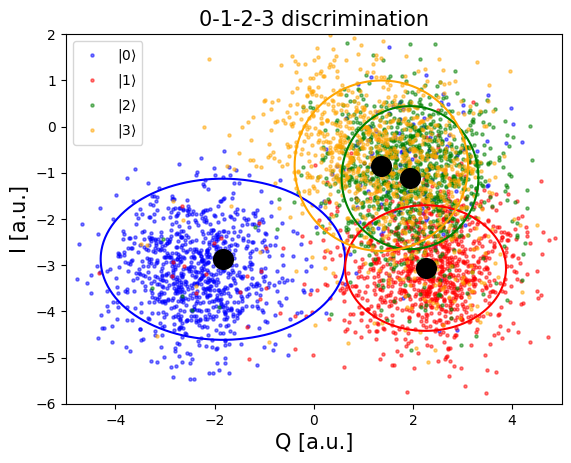

In [157]:
## draw classifier for 0, 1, 2, 3

# zero data plotted in blue
plt.scatter(np.real(zero_data), np.imag(zero_data), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
# one data plotted in red
plt.scatter(np.real(one_data), np.imag(one_data), 
                s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
# two data plotted in green
plt.scatter(np.real(two_data), np.imag(two_data), 
                s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')
# three data plotted in yellow
plt.scatter(np.real(three_data), np.imag(three_data), 
                s=5, cmap='viridis', c='orange', alpha=0.5, label=r'$|3\rangle$')

# Plot a large dot for the average result of the 0, 1 and 2 states.
mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
mean_one = np.mean(one_data)
mean_two = np.mean(two_data)
mean_three = np.mean(three_data)

q_center_zero, i_center_zero = np.real(mean_zero), np.imag(mean_zero)
plt.scatter(q_center_zero, i_center_zero, 
            s=200, cmap='viridis', c='black',alpha=1.0)
q_center_one, i_center_one = np.real(mean_one), np.imag(mean_one)
plt.scatter(q_center_one, i_center_one, 
            s=200, cmap='viridis', c='black',alpha=1.0)
q_center_two, i_center_two = np.real(mean_two), np.imag(mean_two)
plt.scatter(q_center_two, i_center_two,
            s=200, cmap='viridis', c='black',alpha=1.0)
q_center_three, i_center_three = np.real(mean_three), np.imag(mean_three)
plt.scatter(q_center_three, i_center_three,
            s=200, cmap='viridis', c='black',alpha=1.0)

std_devs = 1.5
q_axis_zero, i_axis_zero = std_devs*np.std(np.real(zero_data)), std_devs*np.std(np.imag(zero_data))
draw_ellipse('blue', q_center_zero, i_center_zero, q_axis_zero, i_axis_zero)
q_axis_one, i_axis_one = std_devs*np.std(np.real(one_data)), std_devs*np.std(np.imag(one_data))
draw_ellipse('red', q_center_one, i_center_one, q_axis_one, i_axis_one)
q_axis_two, i_axis_two = std_devs*np.std(np.real(two_data)), std_devs*np.std(np.imag(two_data))
draw_ellipse('green', q_center_two, i_center_two, q_axis_two, i_axis_two)
q_axis_three, i_axis_three = std_devs*np.std(np.real(three_data)), std_devs*np.std(np.imag(three_data))
draw_ellipse('orange', q_center_three, i_center_three, q_axis_three, i_axis_three)

plt.xlim(-5, 5)
plt.ylim(-6, 2)
plt.legend()
plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1-2-3 discrimination", fontsize=15)

### Estimate the occupation probability for |0⟩, |1⟩, |2⟩, and |3⟩ near the calibrated $\pi$ pulse of the |0⟩ → |1⟩ transition

In [158]:
## Set Rabi experiment parameters

# Rabi experiment parameters
num_rabi_points = 75
gap = 0.05

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = pi_amp - gap / 2
drive_amp_max = pi_amp + gap / 2
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [159]:
## create a pulse schedule

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [160]:
## create Rabi circuit

rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

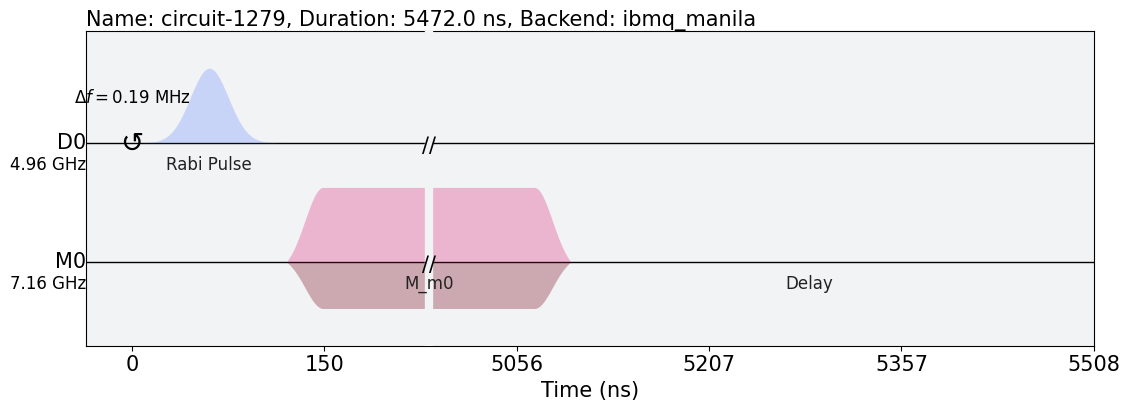

In [161]:
## draw Rabi schedule

rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [162]:
## run assembled program on backend

num_shots_per_point = 1024

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots_per_point)

In [163]:
## monitor job status

job_monitor(job)

Job Status: job has successfully run


In [164]:
## retrieve job results

rabi_results = job.result(timeout=120)

In [165]:
## classify results

ellipses = [(q_center_zero, i_center_zero, q_axis_zero, i_axis_zero),
            (q_center_one, i_center_one, q_axis_one, i_axis_one),
            (q_center_two, i_center_two, q_axis_two, i_axis_two),
            (q_center_three, i_center_three, q_axis_three, i_axis_three)]
            
amp_states = []
amp_classifications_inside = []
amp_classifications_closest = []

for j in range(num_rabi_points):
    states = []
    classifications_inside = []
    classifications_closest = []
    for i in range(num_rabi_points):
        state = rabi_results.get_memory(i)[j]
        states.append(state)
        classifications_inside.append(classify_inside(state * scale_factor, ellipses))
        classifications_closest.append(classify_closest(state * scale_factor, ellipses))

    amp_states.append(np.array(states))
    amp_classifications_inside.append(np.array(classifications_inside))
    amp_classifications_closest.append(np.array(classifications_closest))

In [166]:
max_probability = 0
probabilities_inside = []
probabilities_closest = []
for j in range(len(amp_classifications_inside)):
    num_escaped_inside = np.count_nonzero(amp_classifications_inside[j] == -1) + np.count_nonzero(amp_classifications_inside[j] == 2)
    probability_inside = num_escaped_inside / num_rabi_points
    probabilities_inside.append(probability_inside)
for j in range(len(amp_classifications_closest)):
    num_escaped_closest = np.count_nonzero(amp_classifications_closest[j] == -1) + np.count_nonzero(amp_classifications_closest[j] == 2)
    probability_closest = num_escaped_closest / num_rabi_points
    probabilities_closest.append(probability_closest)

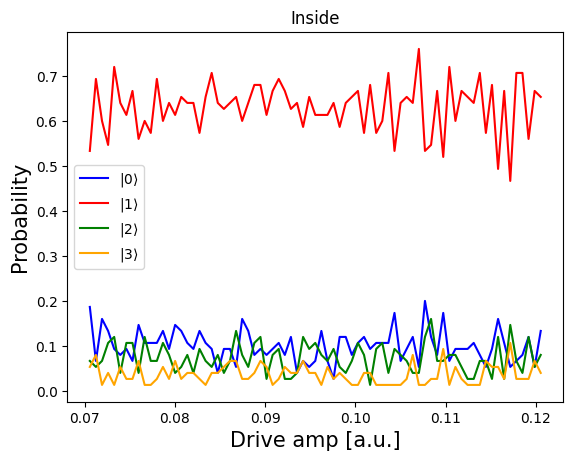

In [169]:
## plot probabilities

zero_probabilities_inside = []
one_probabilities_inside = []
two_probabilities_inside = []
three_probabilities_inside = []
for j in range(len(amp_classifications_inside)):
    num_zero = np.count_nonzero(amp_classifications_inside[j] == 0)
    zero_probabilities_inside.append(num_zero / num_rabi_points)
    num_one = np.count_nonzero(amp_classifications_inside[j] == 1)
    one_probabilities_inside.append(num_one / num_rabi_points)
    num_two = np.count_nonzero(amp_classifications_inside[j] == 2)
    two_probabilities_inside.append(num_two / num_rabi_points)
    num_three = np.count_nonzero(amp_classifications_inside[j] == 3)
    three_probabilities_inside.append(num_three / num_rabi_points)

plt.plot(drive_amps, zero_probabilities_inside, color='blue', label=r'$|0\rangle$')
plt.plot(drive_amps, one_probabilities_inside, color='red', label=r'$|1\rangle$')
plt.plot(drive_amps, two_probabilities_inside, color='green', label=r'$|2\rangle$')
plt.plot(drive_amps, three_probabilities_inside, color='orange', label=r'$|3\rangle$')

plt.title('Inside')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.legend()
plt.show()

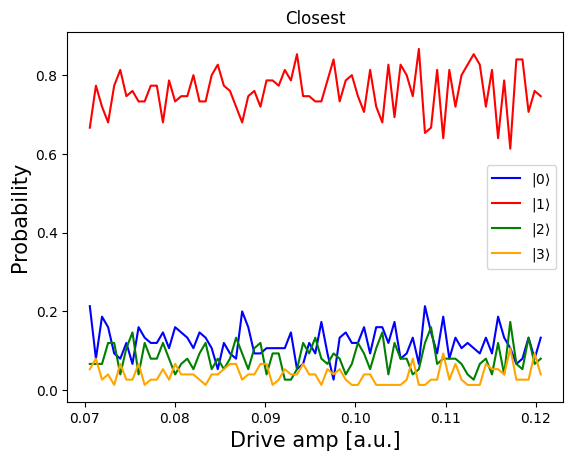

In [170]:
## plot probabilities

zero_probabilities_closest = []
one_probabilities_closest = []
two_probabilities_closest = []
three_probabilities_closest = []
for j in range(len(amp_classifications_closest)):
    num_zero = np.count_nonzero(amp_classifications_closest[j] == 0)
    zero_probabilities_closest.append(num_zero / num_rabi_points)
    num_one = np.count_nonzero(amp_classifications_closest[j] == 1)
    one_probabilities_closest.append(num_one / num_rabi_points)
    num_two = np.count_nonzero(amp_classifications_closest[j] == 2)
    two_probabilities_closest.append(num_two / num_rabi_points)
    num_three = np.count_nonzero(amp_classifications_closest[j] == 3)
    three_probabilities_closest.append(num_three / num_rabi_points)

plt.plot(drive_amps, zero_probabilities_closest, color='blue', label=r'$|0\rangle$')
plt.plot(drive_amps, one_probabilities_closest, color='red', label=r'$|1\rangle$')
plt.plot(drive_amps, two_probabilities_closest, color='green', label=r'$|2\rangle$')
plt.plot(drive_amps, three_probabilities_closest, color='orange', label=r'$|3\rangle$')

plt.title('Closest')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.legend()
plt.show()

### Estimate the occupation probability for |0⟩, |1⟩, and |2⟩ near the calibrated frequency of the |0⟩ → |1⟩ transition

In [200]:
## Drive pulse parameters

gap = 20 * MHz
frequency_min = rough_qubit_frequency - gap / 2
frequency_max = rough_qubit_frequency + gap / 2
frequency_step = 1 * MHz
# Construct an np array of the frequencies for our experiment
frequencies = np.arange(frequency_min, 
                        frequency_max, 
                        frequency_step)

In [201]:
## create a pulse schedule

# Create the base schedule, start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=pi_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [202]:
## create sweep

sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies]

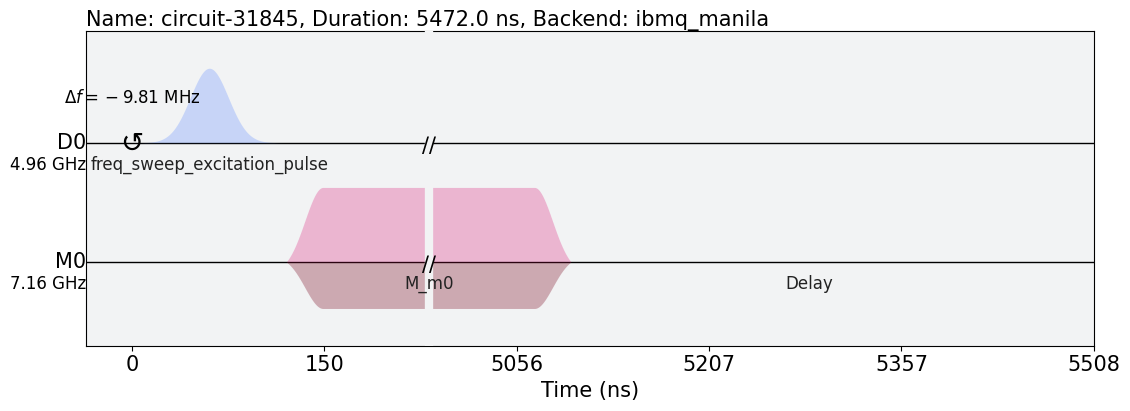

In [203]:
## draw sweep schedule

sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

In [204]:
## run assembled program on backend

num_shots_per_frequency = 1024

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In [205]:
## monitor job status

job_monitor(job)

Job Status: job has successfully run


In [210]:
## retrieve job results

frequency_sweep_results = job.result(timeout=120)

In [211]:
## classify results

ellipses = [(q_center_zero, i_center_zero, q_axis_zero, i_axis_zero),
            (q_center_one, i_center_one, q_axis_one, i_axis_one),
            (q_center_two, i_center_two, q_axis_two, i_axis_two),
            (q_center_three, i_center_three, q_axis_three, i_axis_three)]
            
freq_states = []
freq_classifications_inside = []
freq_classifications_closest = []

for j in range(len(frequencies)):
    states = []
    classifications_inside = []
    classifications_closest = []
    for i in range(num_rabi_points):
        state = rabi_results.get_memory(i)[j]
        states.append(state)
        classifications_inside.append(classify_inside(state * scale_factor, ellipses))
        classifications_closest.append(classify_closest(state * scale_factor, ellipses))

    freq_states.append(np.array(states))
    freq_classifications_inside.append(np.array(classifications_inside))
    freq_classifications_closest.append(np.array(classifications_closest))

In [212]:
max_probability = 0
probabilities_inside = []
probabilities_closest = []
for j in range(len(freq_classifications_inside)):
    num_escaped_inside = np.count_nonzero(freq_classifications_inside[j] == -1) + np.count_nonzero(freq_classifications_inside[j] == 2)
    probability_inside = num_escaped_inside / num_rabi_points
    probabilities_inside.append(probability_inside)
for j in range(len(freq_classifications_closest)):
    num_escaped_closest = np.count_nonzero(freq_classifications_closest[j] == -1) + np.count_nonzero(freq_classifications_closest[j] == 2)
    probability_closest = num_escaped_closest / num_rabi_points
    probabilities_closest.append(probability_closest)

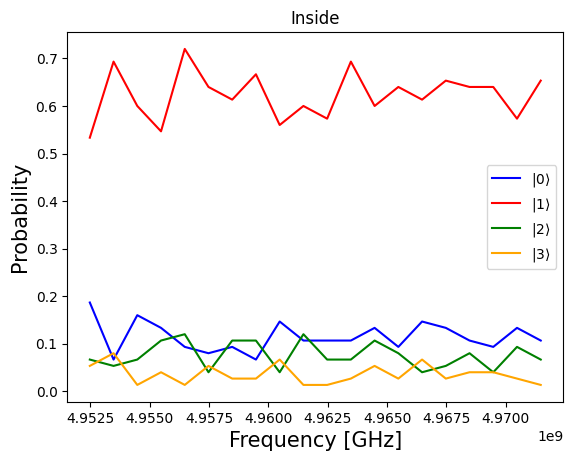

In [213]:
## plot probabilities

zero_probabilities_inside = []
one_probabilities_inside = []
two_probabilities_inside = []
three_probabilities_inside = []
for j in range(len(freq_classifications_inside)):
    num_zero = np.count_nonzero(freq_classifications_inside[j] == 0)
    zero_probabilities_inside.append(num_zero / num_rabi_points)
    num_one = np.count_nonzero(freq_classifications_inside[j] == 1)
    one_probabilities_inside.append(num_one / num_rabi_points)
    num_two = np.count_nonzero(freq_classifications_inside[j] == 2)
    two_probabilities_inside.append(num_two / num_rabi_points)
    num_three = np.count_nonzero(freq_classifications_inside[j] == 3)
    three_probabilities_inside.append(num_three / num_rabi_points)

plt.plot(frequencies, zero_probabilities_inside, color='blue', label=r'$|0\rangle$')
plt.plot(frequencies, one_probabilities_inside, color='red', label=r'$|1\rangle$')
plt.plot(frequencies, two_probabilities_inside, color='green', label=r'$|2\rangle$')
plt.plot(frequencies, three_probabilities_inside, color='orange', label=r'$|3\rangle$')

plt.title('Inside')
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.legend()
plt.show()

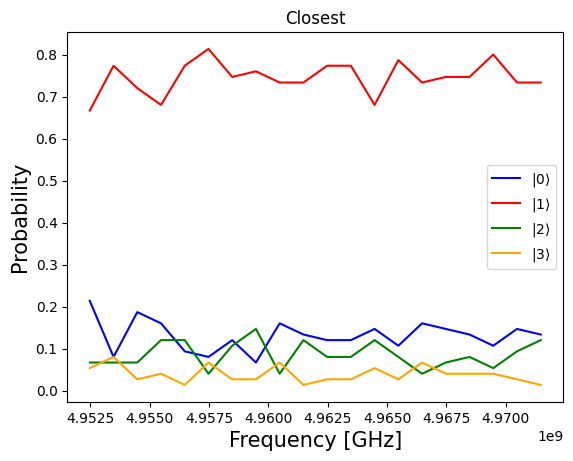

In [214]:
## plot probabilities

zero_probabilities_closest = []
one_probabilities_closest = []
two_probabilities_closest = []
three_probabilities_closest = []
for j in range(len(freq_classifications_closest)):
    num_zero = np.count_nonzero(freq_classifications_closest[j] == 0)
    zero_probabilities_closest.append(num_zero / num_rabi_points)
    num_one = np.count_nonzero(freq_classifications_closest[j] == 1)
    one_probabilities_closest.append(num_one / num_rabi_points)
    num_two = np.count_nonzero(freq_classifications_closest[j] == 2)
    two_probabilities_closest.append(num_two / num_rabi_points)
    num_three = np.count_nonzero(freq_classifications_closest[j] == 3)
    three_probabilities_closest.append(num_three / num_rabi_points)

plt.plot(frequencies, zero_probabilities_closest, color='blue', label=r'$|0\rangle$')
plt.plot(frequencies, one_probabilities_closest, color='red', label=r'$|1\rangle$')
plt.plot(frequencies, two_probabilities_closest, color='green', label=r'$|2\rangle$')
plt.plot(frequencies, three_probabilities_closest, color='orange', label=r'$|3\rangle$')

plt.title('Closest')
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.legend()
plt.show()